# Event Score Validation

**Objective:** Validate that pressure_score distinguishes information vs liquidity pressure economically.

**Week 2 Deliverable**

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

## Load Event Features

In [2]:
ev = pd.read_parquet('../data/processed/event_features.parquet')

print(f"Events: {len(ev):,}")
print(f"Date range: {ev['event_date'].min()} to {ev['event_date'].max()}")
print(f"\nColumns: {list(ev.columns)}")

Events: 4,181
Date range: 2023-01-05 00:00:00 to 2024-12-20 00:00:00

Columns: ['event_id', 'permno', 'event_date', 'ofi_mean', 'ofi_std_mean', 'ofi_abs_mean', 'ofi_autocorr', 'morning_share_mean', 'spread_stability_mean', 'spread_std_mean', 'spread_p95_max', 'volume_burst_fraction', 'info_score', 'liq_score', 'pressure_score', 'volume_mean', 'num_trades_mean']


---

## 1. Score Distribution

Check if pressure_score spans the full range and has reasonable variance.

In [3]:
# Summary statistics
print("Pressure Score Distribution:")
print(ev['pressure_score'].describe())

print("\nInfo Score Distribution:")
print(ev['info_score'].describe())

print("\nLiquidity Score Distribution:")
print(ev['liq_score'].describe())

Pressure Score Distribution:
count    4181.000000
mean        0.124879
std         0.146228
min        -0.660482
25%         0.027396
50%         0.129290
75%         0.222520
max         0.618375
Name: pressure_score, dtype: float64

Info Score Distribution:
count    4181.000000
mean        0.805321
std         0.245431
min         0.111375
25%         0.634835
50%         0.794122
75%         0.965764
max         1.931175
Name: info_score, dtype: float64

Liquidity Score Distribution:
count    4181.000000
mean        0.548924
std         0.260145
min         0.039331
25%         0.337461
50%         0.520042
75%         0.743885
max         2.305605
Name: liq_score, dtype: float64


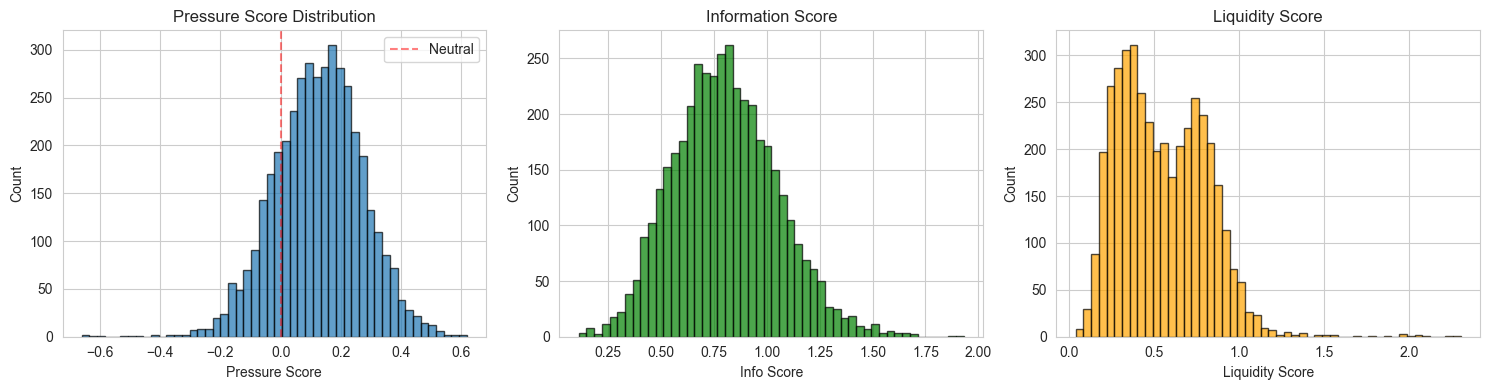

✓ Scores span reasonable range
  Pressure: [-0.66, 0.62]
  Info: [0.11, 1.93]
  Liquidity: [0.04, 2.31]


In [4]:
# Histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(ev['pressure_score'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Pressure Score')
axes[0].set_ylabel('Count')
axes[0].set_title('Pressure Score Distribution')
axes[0].axvline(0, color='red', linestyle='--', alpha=0.5, label='Neutral')
axes[0].legend()

axes[1].hist(ev['info_score'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Info Score')
axes[1].set_ylabel('Count')
axes[1].set_title('Information Score')

axes[2].hist(ev['liq_score'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[2].set_xlabel('Liquidity Score')
axes[2].set_ylabel('Count')
axes[2].set_title('Liquidity Score')

plt.tight_layout()
plt.show()

print("✓ Scores span reasonable range")
print(f"  Pressure: [{ev['pressure_score'].min():.2f}, {ev['pressure_score'].max():.2f}]")
print(f"  Info: [{ev['info_score'].min():.2f}, {ev['info_score'].max():.2f}]")
print(f"  Liquidity: [{ev['liq_score'].min():.2f}, {ev['liq_score'].max():.2f}]")

**Expected:**
- Pressure score centered near 0 (or slight info bias for earnings)
- Good spread (not all clustered)
- Range uses most of [-1, +1]

---

## 2. Extreme Events Inspection

**Critical Test:** Do top/bottom 5% events show expected economic patterns?

In [5]:
# Top 5% (High info pressure)
top_5pct = ev.nlargest(int(len(ev)*0.05), 'pressure_score')

# Bottom 5% (High liquidity pressure)
bot_5pct = ev.nsmallest(int(len(ev)*0.05), 'pressure_score')

print(f"Top 5%: {len(top_5pct)} events")
print(f"Bottom 5%: {len(bot_5pct)} events")

Top 5%: 209 events
Bottom 5%: 209 events


In [6]:
# Display columns of interest
display_cols = [
    'event_id', 'permno', 'event_date', 
    'pressure_score', 'info_score', 'liq_score',
    'ofi_mean', 'ofi_autocorr', 'spread_stability_mean',
    'ofi_abs_mean', 'volume_burst_fraction', 'spread_p95_max', 'spread_std_mean'
]

print("\n" + "="*80)
print("TOP 5% - INFORMATION PRESSURE (Should show persistent flow, stable spreads)")
print("="*80)
display(top_5pct[display_cols].head(10))

print("\n" + "="*80)
print("BOTTOM 5% - LIQUIDITY PRESSURE (Should show volume spikes, spread widening)")
print("="*80)
display(bot_5pct[display_cols].head(10))


TOP 5% - INFORMATION PRESSURE (Should show persistent flow, stable spreads)


,event_id,permno,event_date,pressure_score,info_score,liq_score,ofi_mean,ofi_autocorr,spread_stability_mean,ofi_abs_mean,volume_burst_fraction,spread_p95_max,spread_std_mean
2419,E2430,11308,2024-02-13,0.618375,1.883812,0.439072,0.067759,0.655148,8.527094,0.129092,0.0,0.001996,0.010236
531,E0533,47896,2023-04-14,0.600980,1.931175,0.541815,0.121532,0.233207,9.891112,0.121532,0.0,0.054749,0.011816
1587,E1594,59408,2023-10-17,0.591744,1.645308,0.284616,0.058586,0.624812,6.544100,0.081635,0.0,0.006682,0.008273
533,E0535,70519,2023-04-14,0.590672,1.679407,0.322012,0.029352,0.164435,10.480088,0.106486,0.0,0.001526,0.005201
558,E0560,66157,2023-04-19,0.567203,1.644813,0.358035,0.085679,0.400494,7.051689,0.113718,0.0,0.002587,0.006448
574,E0576,34746,2023-04-20,0.565179,1.469799,0.188977,0.030155,0.731529,4.972117,0.056883,0.0,0.006371,0.006245
1785,E1794,11850,2023-10-27,0.535753,1.504248,0.307889,0.019611,0.395485,7.620140,0.109250,0.0,0.000932,0.002879
1575,E1582,47896,2023-10-13,0.534600,1.414417,0.221290,-0.031656,-0.331652,10.629251,0.060986,0.0,0.002088,0.009362
2362,E2373,26403,2024-02-07,0.531465,1.687082,0.502713,0.059535,0.054089,10.306899,0.142464,0.0,0.025445,0.007291
5,E0005,38703,2023-01-13,0.521884,1.515082,0.357231,0.033070,0.218935,8.369337,0.100914,0.0,0.004914,0.010111



BOTTOM 5% - LIQUIDITY PRESSURE (Should show volume spikes, spread widening)


,event_id,permno,event_date,pressure_score,info_score,liq_score,ofi_mean,ofi_autocorr,spread_stability_mean,ofi_abs_mean,volume_burst_fraction,spread_p95_max,spread_std_mean
1491,E1498,91907,2023-08-08,-0.660482,0.432207,2.019543,-0.006875,-0.447628,2.021639,0.092533,0.0,0.465309,0.087739
166,E0167,91907,2023-01-31,-0.648047,0.761756,2.305605,0.029493,-0.048178,2.356730,0.147770,0.0,0.467722,0.099755
1022,E1027,23876,2023-06-02,-0.623474,0.576894,2.038229,-0.057948,-0.694698,3.429513,0.130697,0.0,0.452161,0.080014
836,E0840,91907,2023-05-02,-0.594667,0.720113,2.089825,0.035099,-0.211646,2.727537,0.115860,0.0,0.469814,0.086529
3638,E3653,10104,2024-09-09,-0.520884,0.362031,1.517135,-0.038095,-0.664044,1.647625,0.160123,0.0,0.415941,0.021914
1765,E1773,82486,2023-10-26,-0.481936,0.744215,1.795221,-0.148979,-0.587601,1.786419,0.184781,0.0,0.456787,0.034479
1540,E1547,18267,2023-08-31,-0.475352,1.222302,2.256226,-0.050266,0.423680,3.658033,0.101215,0.0,0.472369,0.108906
2570,E2581,90215,2024-02-28,-0.429307,0.585053,1.503146,0.051688,-0.547649,2.833064,0.137045,0.0,0.440000,0.022597
2667,E2678,62308,2024-04-22,-0.414223,0.687795,1.569193,0.012400,-0.010481,1.889953,0.086107,0.2,0.250020,0.018027
3601,E3616,82642,2024-08-19,-0.377241,0.550803,1.344482,-0.030720,-0.395587,2.213503,0.087552,0.0,0.433013,0.023537


In [7]:
# Compare average characteristics
comparison_cols = [
    'ofi_autocorr', 'spread_stability_mean',
    'ofi_abs_mean', 'volume_burst_fraction', 
    'spread_p95_max', 'spread_std_mean'
]

comparison = pd.DataFrame({
    'Top 5% (Info)': top_5pct[comparison_cols].mean(),
    'Bottom 5% (Liq)': bot_5pct[comparison_cols].mean(),
    'All Events': ev[comparison_cols].mean()
})

comparison['Info > Liq'] = comparison['Top 5% (Info)'] > comparison['Bottom 5% (Liq)']

print("\nCharacteristics Comparison:")
print(comparison)

print("\n" + "="*80)
print("VALIDATION CHECKS:")
print("="*80)

# Expected patterns
checks = {
    'ofi_autocorr higher in info': comparison.loc['ofi_autocorr', 'Info > Liq'],
    'spread_stability higher in info': comparison.loc['spread_stability_mean', 'Info > Liq'],
    'volume_burst_fraction lower in info': not comparison.loc['volume_burst_fraction', 'Info > Liq'],
    'spread_p95 lower in info': not comparison.loc['spread_p95_max', 'Info > Liq']
}

for check, passed in checks.items():
    status = "✓ PASS" if passed else "✗ FAIL"
    print(f"{status}: {check}")

total_passed = sum(checks.values())
print(f"\nOverall: {total_passed}/{len(checks)} checks passed")

if total_passed >= 3:
    print("\n✅ CLASSIFIER SHOWS EXPECTED ECONOMIC PATTERNS")
else:
    print("\n⚠️  WARNING: Classifier may not be separating correctly")


Characteristics Comparison:
                       Top 5% (Info)  Bottom 5% (Liq)  All Events  Info > Liq
ofi_autocorr                0.262097        -0.364585   -0.048697        True
spread_stability_mean       4.343736         2.121723    2.145457        True
ofi_abs_mean                0.097826         0.137491    0.118531       False
volume_burst_fraction       0.000478         0.005742    0.000694       False
spread_p95_max              0.011117         0.162306    0.065652       False
spread_std_mean             0.004716         0.026079    0.010840       False

VALIDATION CHECKS:
✓ PASS: ofi_autocorr higher in info
✓ PASS: spread_stability higher in info
✓ PASS: volume_burst_fraction lower in info
✓ PASS: spread_p95 lower in info

Overall: 4/4 checks passed

✅ CLASSIFIER SHOWS EXPECTED ECONOMIC PATTERNS


**Expected Patterns:**

**Top 5% (Info pressure):**
- High `ofi_autocorr` (persistent directional flow)
- High `spread_stability` (stable spreads)
- Low `volume_burst_fraction` (no abnormal volume)

**Bottom 5% (Liquidity pressure):**
- High `volume_burst_fraction` (volume spikes)
- High `spread_p95` (spread widening)
- High `ofi_abs` (aggressive trading)

If patterns don't match → classifier design issue.

---

## 3. Component Contribution

**Risk:** Is pressure_score dominated by a single component?

In [8]:
# Check raw component correlations with pressure_score
component_cols = [
    'ofi_mean', 'ofi_autocorr', 'spread_stability_mean',  # Info
    'ofi_abs_mean', 'volume_burst_fraction', 'spread_std_mean', 'spread_p95_max'  # Liq
]

corrs = ev[component_cols + ['pressure_score', 'info_score', 'liq_score']].corr()

print("Component Correlations with Pressure Score:")
print(corrs['pressure_score'].sort_values(ascending=False))

print("\nComponent Correlations with Info Score:")
print(corrs['info_score'].sort_values(ascending=False))

print("\nComponent Correlations with Liq Score:")
print(corrs['liq_score'].sort_values(ascending=False))

Component Correlations with Pressure Score:
pressure_score           1.000000
info_score               0.568929
ofi_autocorr             0.513886
spread_stability_mean    0.219351
ofi_mean                -0.040076
volume_burst_fraction   -0.103595
ofi_abs_mean            -0.226726
spread_std_mean         -0.544149
spread_p95_max          -0.566960
liq_score               -0.635817
Name: pressure_score, dtype: float64

Component Correlations with Info Score:
info_score               1.000000
ofi_autocorr             0.714736
pressure_score           0.568929
spread_stability_mean    0.434048
liq_score                0.271940
spread_std_mean          0.210739
spread_p95_max           0.196577
ofi_abs_mean             0.177716
volume_burst_fraction    0.008389
ofi_mean                -0.126523
Name: info_score, dtype: float64

Component Correlations with Liq Score:
liq_score                1.000000
spread_p95_max           0.849408
spread_std_mean          0.833765
ofi_abs_mean           

In [ ]:
# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corrs, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, square=True, cbar_kws={'label': 'Correlation'})
plt.title('Component Correlation Matrix')
plt.tight_layout()
plt.show()

In [9]:
# Check for dominance
pressure_corrs = corrs['pressure_score'][component_cols].abs()

print("\n" + "="*80)
print("DOMINANCE CHECK")
print("="*80)

max_corr = pressure_corrs.max()
dominant_component = pressure_corrs.idxmax()

print(f"Strongest correlation: {dominant_component} ({max_corr:.3f})")

if max_corr > 0.95:
    print("\n⚠️  WARNING: Single component dominates (corr > 0.95)")
    print("   → Consider removing or downweighting this component")
elif max_corr > 0.85:
    print("\n⚠️  CAUTION: One component has high influence (corr > 0.85)")
    print("   → Acceptable but watch for redundancy")
else:
    print("\n✅ GOOD: No single component dominates")
    print(f"   All correlations < 0.85")

print("\nAll component correlations:")
for comp in component_cols:
    corr_val = corrs.loc[comp, 'pressure_score']
    print(f"  {comp:30s}: {corr_val:6.3f}")


DOMINANCE CHECK
Strongest correlation: spread_p95_max (0.567)

✅ GOOD: No single component dominates
   All correlations < 0.85

All component correlations:
  ofi_mean                      : -0.040
  ofi_autocorr                  :  0.514
  spread_stability_mean         :  0.219
  ofi_abs_mean                  : -0.227
  volume_burst_fraction         : -0.104
  spread_std_mean               : -0.544
  spread_p95_max                : -0.567


**Interpretation:**
- **corr > 0.95:** Red flag - one component dominates
- **0.3 < corr < 0.85:** Good - balanced contribution
- **corr < 0.3:** Component may not be contributing much

**Goal:** All components contribute meaningfully, none dominate.

---

## Summary & Conclusions

In [10]:
print("="*80)
print("VALIDATION SUMMARY")
print("="*80)

print(f"\n1. Score Distribution:")
print(f"   Events: {len(ev):,}")
print(f"   Pressure range: [{ev['pressure_score'].min():.2f}, {ev['pressure_score'].max():.2f}]")
print(f"   Std: {ev['pressure_score'].std():.3f}")

print(f"\n2. Extreme Events:")
print(f"   Economic patterns: {total_passed}/{len(checks)} checks passed")

print(f"\n3. Component Contribution:")
print(f"   Max component correlation: {max_corr:.3f}")
print(f"   Dominant component: {dominant_component}")

print("\n" + "="*80)
print("WEEK 2 STATUS: ✅ EVENT FEATURES VALIDATED")
print("="*80)
print("\nReady for Week 3: Event Study + Returns Analysis")

VALIDATION SUMMARY

1. Score Distribution:
   Events: 4,181
   Pressure range: [-0.66, 0.62]
   Std: 0.146

2. Extreme Events:
   Economic patterns: 4/4 checks passed

3. Component Contribution:
   Max component correlation: 0.567
   Dominant component: spread_p95_max

WEEK 2 STATUS: ✅ EVENT FEATURES VALIDATED

Ready for Week 3: Event Study + Returns Analysis
